#### <b>Importing The Required Libraries</b>

In [ ]:
# Import necessary libraries
import pandas as pd  # For handling tabular data
import cv2  # OpenCV for image processing
import os  # For file and directory operations
from tqdm import tqdm  # For showing progress bars in loops
import random  # For random selection/shuffling of data
from collections import Counter  # For counting occurrences of elements in a dataset
import seaborn as sns # for data visualization

### <b>Data Importation</b>

In [3]:
#listing out the directory
directory = '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [4]:
# Initialize a list to hold the data
data = []

# Loop through each category
for category in tqdm(categories, desc="Processing Categories"):

    category_path = os.path.join(directory, category)

    # Check if the directory exists
    if os.path.exists(category_path):
        # Loop through each file in the category directory
        for file_name in tqdm(os.listdir(category_path), desc=f"Processing Files in {category}", leave=False):
            file_path = os.path.join(category_path, file_name)

            # Check if it's a file (to avoid directories)
            if os.path.isfile(file_path):
                # Append the file path and label to the data list
                data.append((file_path, category))
    else:
        print(f"Directory not found: {category_path}")

# Randomize the data
random.shuffle(data)
# Create a pandas DataFrame
df = pd.DataFrame(data, columns=['File_Path', 'Label'])


# Define label encoding
label_encoding = {'Bengin cases': 0, 'Malignant cases': 1, 'Normal cases': 2}

# Map the labels to their corresponding numerical values
df['Encoded_Label'] = df['Label'].map(label_encoding)

# Display the first few rows of the DataFrame
df.head()

Processing Categories: 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]                


,File_Path,Label,Encoded_Label
0,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Malignant cases,1
1,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases,0
2,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases,0
3,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Normal cases,2
4,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Malignant cases,1


### <b>Data Cleaning and Conversion</b>

In [5]:
# Define the target image size
img_size = 256

# Function to process images: resize to 256x256, convert to grayscale
def process_image(file_path):
    # Read the image in grayscale
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        # Resize the image
        img_resized = cv2.resize(img, (img_size, img_size))
        return img_resized  # Return as a 2D numpy array
    else:
        print(f"Image not found or could not be read: {file_path}")
        return None

# Use tqdm to apply the function with a progress bar
tqdm.pandas(desc="Processing Images")
df['Processed_Image'] = df['File_Path'].progress_apply(process_image)

# Remove rows with None (failed image processing)
df = df.dropna(subset=['Processed_Image']).reset_index(drop=True)

Processing Images: 100%|██████████| 1097/1097 [00:24<00:00, 45.10it/s]


### <b>Data Normalization</b>

In [6]:
import numpy as np

In [8]:
# Convert the column of processed images into a 3D NumPy array
X = [img for img in df['Processed_Image']]  # Collect images into a list
X = np.array(X).reshape(-1, img_size, img_size, 1)  # Add channel dimension
X= X/255.0

y= df['Label']
y= np.array(y)

### <b>Data Splitting</b>

In [9]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [10]:
#Splitting the data into train, test and validation set
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp,y_temp, test_size=0.2, random_state=42)

### <b>Applying SMOTE</b>

In [11]:
# Flatten X_train for SMOTE
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Shape: (n_samples, img_size * img_size)

# Apply SMOTE
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled_flattened, y_train_sampled = smote.fit_resample(X_train_flattened, y_train)
print('After SMOTE:', Counter(y_train_sampled))

# Reshape X_train_sampled back to 4D
X_train_sampled = X_train_sampled_flattened.reshape(-1, img_size, img_size, 1)  # Shape: (n_samples, img_size, img_size, 1)

Before SMOTE: Counter({'Malignant cases': 455, 'Normal cases': 330, 'Bengin cases': 92})
After SMOTE: Counter({'Bengin cases': 455, 'Malignant cases': 455, 'Normal cases': 455})


In [12]:
label_encoding = {'Bengin cases': 0, 'Malignant cases': 1, 'Normal cases': 2}
y_train_sampled = np.array([label_encoding[label] for label in y_train_sampled])
y_val = np.array([label_encoding[label] for label in y_val])
y_test = np.array([label_encoding[label] for label in y_test])

### <b>Model Building</b>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

In [15]:
# Define L2 regularizer
l2_reg = l2(0.0001)

# Define the model using Sequential([]) notation
model1 = Sequential([
    Conv2D(32, (3, 3), input_shape=X_train.shape[1:], kernel_regularizer=l2_reg),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2_reg),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(16, kernel_regularizer=l2_reg),
    Dropout(0.5),
    Dense(3, activation='softmax', kernel_regularizer=l2_reg)
])

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 254, 254, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │       1,843,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,935,939 (7.39 MB)

 Trainable params: 1,935,939 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

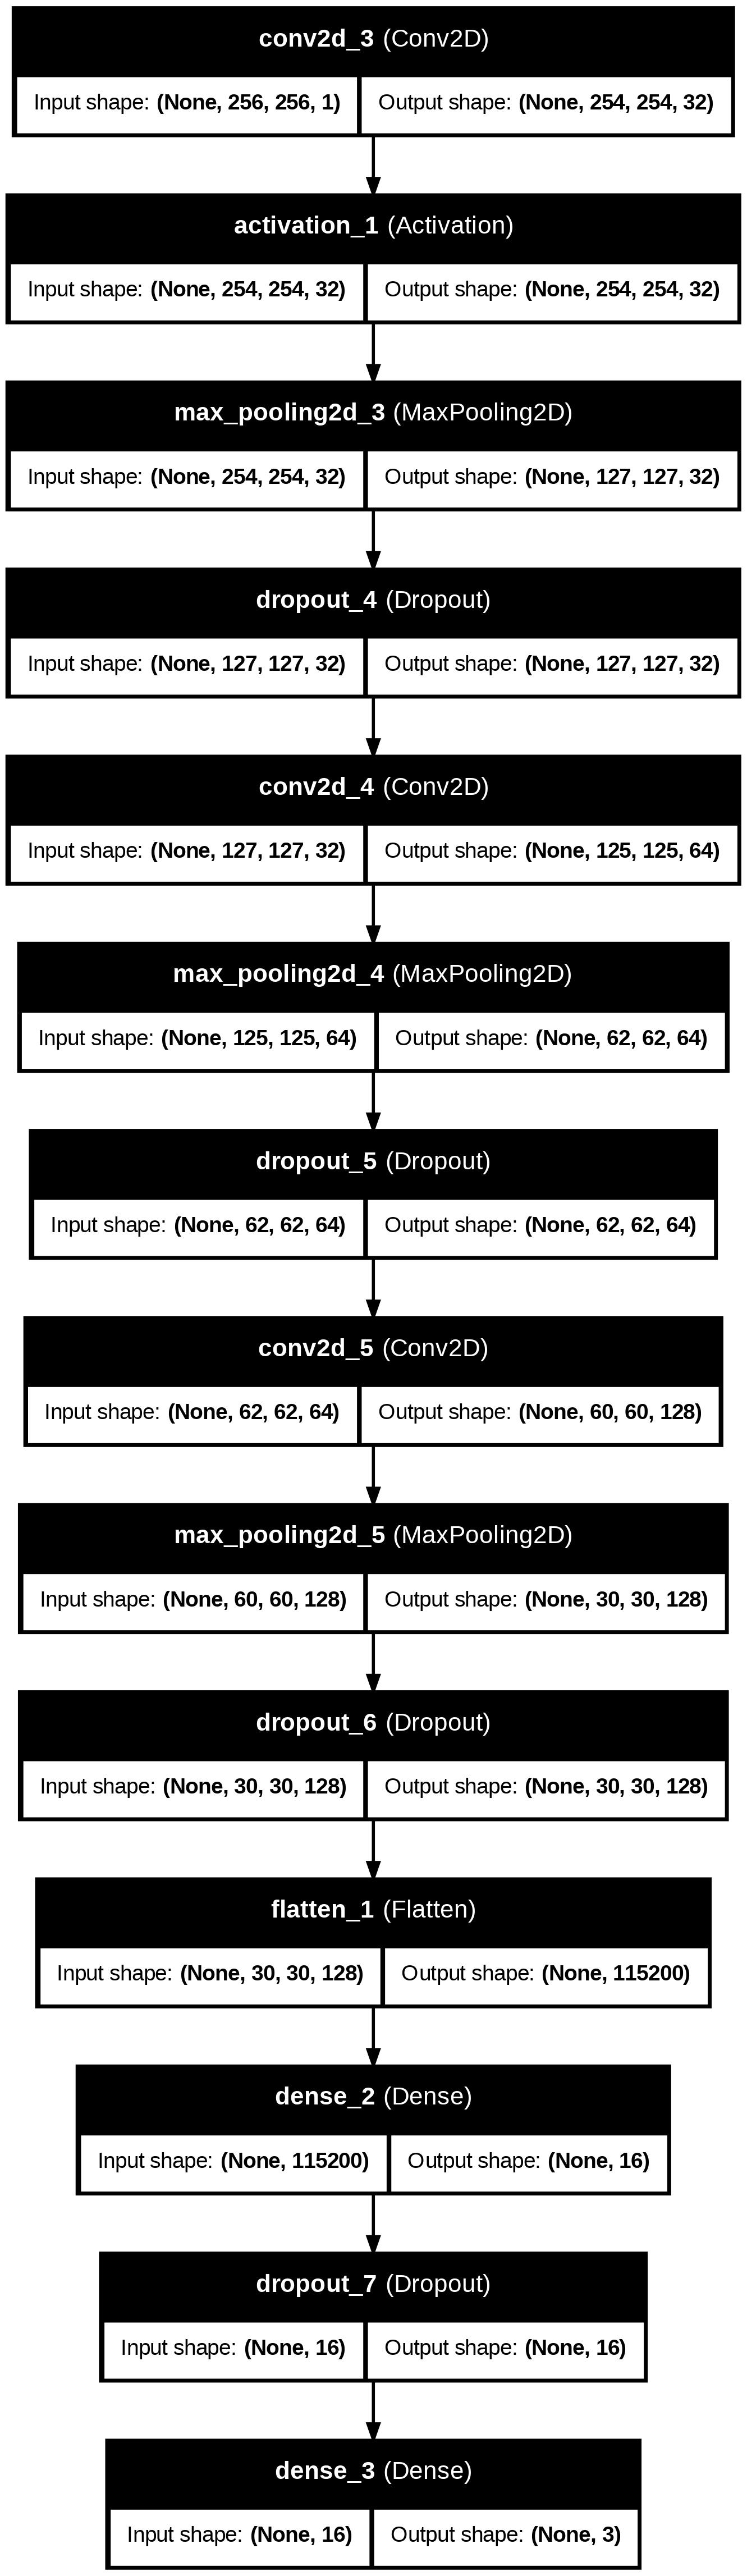

In [16]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture to a file
plot_model(
    model1,
    to_file='model_plot.png',
    show_shapes=True,  # Displays the shape of input/output tensors
    show_layer_names=True  # Displays layer names
)

In [17]:
# Step 1: Dencode labels
label_encoding = {'Bengin cases': 0, 'Malignant cases': 1, 'Normal cases': 2}
y_train_encoded = [label_encoding[label] for label in y_train]  # Encode y_train

# Step 2: Count the occurrences of each class in the encoded labels
class_counts = Counter(y_train_encoded)

# Step 3: Calculate weights
new_weights = {
    0: X_train.shape[0] / (3 * class_counts[0]),
    1: X_train.shape[0] / (3 * class_counts[1]),
    2: X_train.shape[0] / (3 * class_counts[2]),
}

new_weights

{0: 3.177536231884058, 1: 0.6424908424908425, 2: 0.8858585858585859}

In [18]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=3,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore weights of the best epoch
)

### <b>Model Training</b>

In [20]:
 # Train the model with Early Stopping

history = model1.fit(
    X_train_sampled,
    y_train_sampled,
    batch_size=8,
    epochs=15,
    validation_data=(X_val, y_val),
    class_weight=new_weights,
    callbacks=[early_stopping]  # Add the callback here
)

Epoch 1/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.3718 - loss: 2.3182 - val_accuracy: 0.1818 - val_loss: 1.1765
Epoch 2/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5377 - loss: 1.0711 - val_accuracy: 0.6364 - val_loss: 0.6712
Epoch 3/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7608 - loss: 0.6210 - val_accuracy: 0.9318 - val_loss: 0.2893
Epoch 4/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8620 - loss: 0.3850 - val_accuracy: 0.9091 - val_loss: 0.2695
Epoch 5/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8864 - loss: 0.3404 - val_accuracy: 0.9773 - val_loss: 0.1655
Epoch 6/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9218 - loss: 0.2356 - val_accuracy: 0.9318 - val_loss: 0.2324
Epoch 7/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9255 - loss: 0.2267 - val_accuracy: 1.0000 - val_loss: 0.0935
Epoch 8/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9492 - loss: 0.1842 - val_acc

### <b>Model Evaluation</b>

In [ ]:
# Predictions from model 1 (probabilities)
y_pred = model1.predict(X_test, verbose=0)
# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate Accuracy, F1 Score and AUC for model 1
accuracy_model1 = accuracy_score(y_test, y_pred_labels)
f1_model1 = f1_score(y_test, y_pred_labels, average="weighted")
auc_model1 = roc_auc_score(y_test, y_pred, multi_class="ovr")

print("Evaluation on Test Data")
print("Model Accuracy: {:.2f}%".format(accuracy_model1 * 100))
print("Model F1 Score: {:.2f}%".format(f1_model1 * 100))
print("Model AUC Score: {:.4f}".format(auc_model1))

Evaluation on Test Data
Model Accuracy: 98.34%
Model F1 Score: 98.34%
Model AUC Score: 0.9993


### <b> Result Visualization </b> 

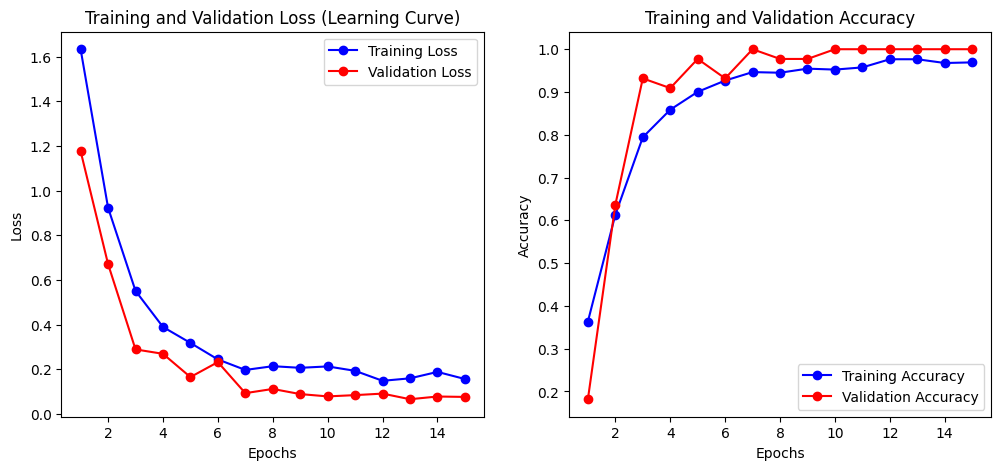

In [42]:
import matplotlib.pyplot as plt

# Extract values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss (Learning Curve)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

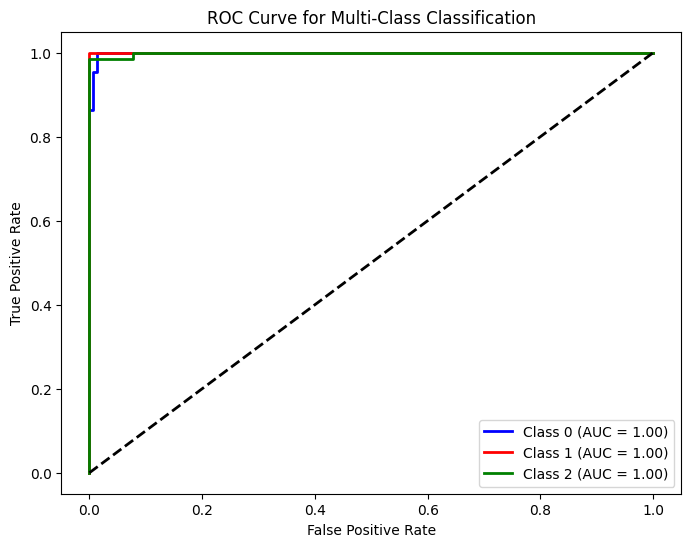

In [ ]:
n_classes = 3  # Since we have 3 classes
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Random chance diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()

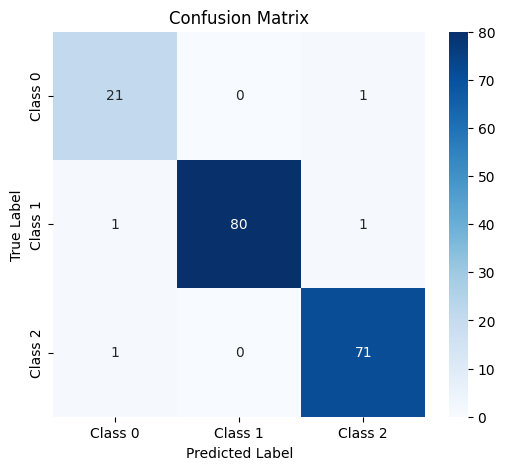

In [ ]:
# 📌 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)

# 📊 Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [46]:
#saving the model
model1.save("Ismail_lung_model.h5")

### Converting to TensorFLow LITE

In [47]:
# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()

# Save the converted TFLite model
with open('Ismail-Lung-Model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TFLite format successfully!")

Saved artifact at '/tmp/tmpj2juts35'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135352098374048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135352098607472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135352098438160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135352098610112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135352098612224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135352098610288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135352098604480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135352098608352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135352098612928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135352098614512: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model convert

In [48]:
os.listdir()

['Ismail_lung_model.h5',
 'Ismail-Lung-Model.tflite',
 '.virtual_documents',
 'model_plot.png']

### THE END